In [1]:
import quandl
import datetime
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from IPython.display import display
from ipywidgets import widgets,interact
drop = widgets.Dropdown(options={'XNYS/ABC':'XNYS/ABC', 'XNYS/ADM':'XNYS/ADM', 'XNYS/ADC':'XNYS/ADC'},description='Number:',)
text = widgets.Text(placeholder='api key',description='ENTER API',disabled=False)
def handle_submit(sender):
    print("You have entered the following api key :",text.value)

In [3]:
display(text)
text.on_submit(handle_submit)


Text(value='', description='ENTER API', placeholder='api key')

You have entered the following api key : zBB47po91xSHtU9dgDx_


In [4]:
display(drop)


Dropdown(description='Number:', options={'XNYS/ABC': 'XNYS/ABC', 'XNYS/ADM': 'XNYS/ADM', 'XNYS/ADC': 'XNYS/ADC'}, value='XNYS/ABC')

In [5]:
field2=drop.value
api=text.value
class data():
    model=None
    
    def get_data(self):
        try:
            quandl.ApiConfig.api_key = api
            self.df=quandl.get(field2)
            print('loading data')
            self.data=0
            return self.df
        except Exception as f:
                print("{} following error occured please look into the code again".format(f))
    
    def process_data(self):
        self.get_data()
        self.data = self.df
        self.data.to_csv("data_{}.csv".format(datetime.date.today()))
        print('Data saved to local system')
        return self.data

In [6]:
dat = data()
df = dat.process_data()

loading data
Data saved to local system


In [7]:
valid_set_size_percentage = 10 
test_set_size_percentage = 10

In [8]:
df = df.drop(columns=['Adjustment Factor','Adjustment Type'])

In [9]:
df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2006-12-28,19.500427,19.513373,19.370971,19.435699,1272600.0
2006-12-29,19.401178,19.478851,19.383917,19.401178,2038800.0
2007-01-01,19.401178,19.401178,19.401178,19.401178,0.0
2007-01-02,19.401178,19.401178,19.401178,19.401178,0.0
2007-01-03,19.452960,19.914687,19.452960,19.897427,4141600.0


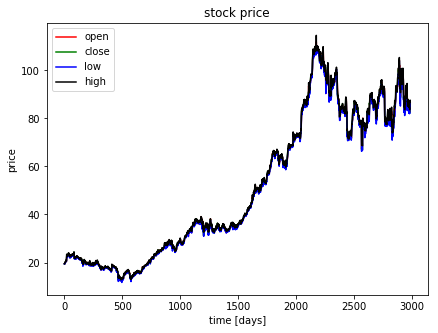

In [10]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df['Open'].values, color='red', label='open')
plt.plot(df['Close'].values, color='green', label='close')
plt.plot(df['Low'].values, color='blue', label='low')
plt.plot(df['High'].values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
plt.show()

plt.subplot(1,2,2);
plt.plot(df['Volume'].values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [11]:
# Normalizing the data using min-max normalisation
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df['Open'].values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df['High'].values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df['Low'].values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df

# Creating train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() 
    data = []

    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


df_stock = df.copy()
df_stock.drop(['Volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)


df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

seq_len = 20 
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

df_stock.columns.values =  ['Open', 'High', 'Low', 'Close']
x_train.shape =  (2373, 19, 4)
y_train.shape =  (2373, 4)
x_valid.shape =  (297, 19, 4)
y_valid.shape =  (297, 4)
x_test.shape =  (297, 19, 4)
y_test.shape =  (297, 4)


In [12]:
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

In [13]:
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array)
        start = 0 
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [14]:
# parameters for training
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

In [15]:
# Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

In [16]:
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] 
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)


In [17]:
#saver = tf.train.Saver()
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size)  
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
    #saver.save(sess, "./tmp/model.ckpt") 

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    

0.00 epochs: MSE train/valid = 0.359577/0.901078
4.99 epochs: MSE train/valid = 0.000097/0.000436
9.99 epochs: MSE train/valid = 0.000079/0.000365
14.98 epochs: MSE train/valid = 0.000070/0.000293
19.97 epochs: MSE train/valid = 0.000146/0.000552
24.97 epochs: MSE train/valid = 0.000062/0.000250
29.96 epochs: MSE train/valid = 0.000042/0.000212
34.96 epochs: MSE train/valid = 0.000043/0.000215
39.95 epochs: MSE train/valid = 0.000068/0.000300
44.94 epochs: MSE train/valid = 0.000064/0.000293
49.94 epochs: MSE train/valid = 0.000041/0.000188
54.93 epochs: MSE train/valid = 0.000036/0.000170
59.92 epochs: MSE train/valid = 0.000041/0.000187
64.92 epochs: MSE train/valid = 0.000049/0.000233
69.91 epochs: MSE train/valid = 0.000033/0.000171
74.91 epochs: MSE train/valid = 0.000039/0.000186
79.90 epochs: MSE train/valid = 0.000035/0.000169
84.89 epochs: MSE train/valid = 0.000032/0.000154
89.89 epochs: MSE train/valid = 0.000029/0.000160
94.88 epochs: MSE train/valid = 0.000029/0.000166
99.

correct sign prediction for close - open price for train/valid/test: 0.98/0.95/0.93


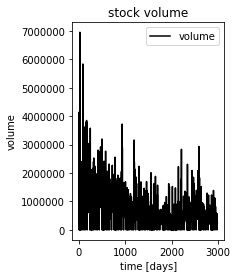

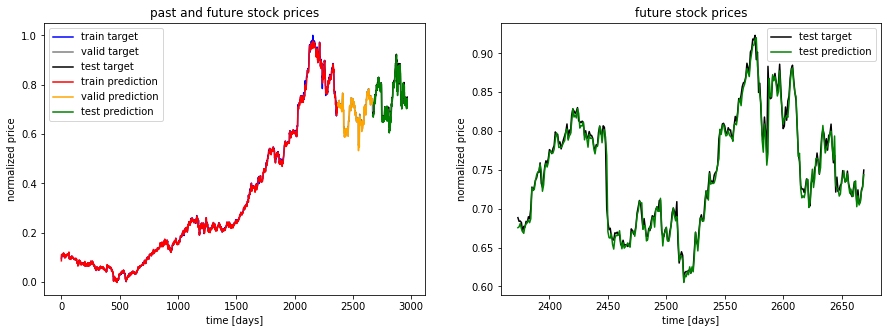

In [18]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

# predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))
plt.show()